In [1]:
import re
import nltk
import nlp 
nltk.download('stopwords')
import pandas as pd
import numpy as np

#genism
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LdaModel

#spacy for lemmatization
import spacy

#plotting tools
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to C:\Users\Harmanpreet
[nltk_data]     Kaur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('bbc-text.csv')

In [3]:
df.shape

(2225, 2)

In [4]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


#4. Preprocessing data:

→ Remove emails, newline characters, stop words, and perform tokenization.

In [5]:
#converting to list
data = df.text.values.tolist()

#remove email
data = [re.sub('\S*@\S*\s', '' ,i) for i in data]

#remove new line characters
data = [re.sub('\s+', ' ' ,i) for i in data]

#removing distracting single quotes
data = [re.sub("\'", "" ,i) for i in data]

<>:5: DeprecationWarning: invalid escape sequence \S
<>:8: DeprecationWarning: invalid escape sequence \s
<>:5: DeprecationWarning: invalid escape sequence \S
<>:8: DeprecationWarning: invalid escape sequence \s
C:\Users\Harmanpreet Kaur\AppData\Local\Temp\ipykernel_28892\1498987124.py:5: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s', '' ,i) for i in data]
C:\Users\Harmanpreet Kaur\AppData\Local\Temp\ipykernel_28892\1498987124.py:8: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ' ,i) for i in data]


In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),deacc=True))

data_words = list(sent_to_words(data))

print(data_words[:1])

[['tv', 'future', 'in', 'the', 'hands', 'of', 'viewers', 'with', 'home', 'theatre', 'systems', 'plasma', 'high', 'definition', 'tvs', 'and', 'digital', 'video', 'recorders', 'moving', 'into', 'the', 'living', 'room', 'the', 'way', 'people', 'watch', 'tv', 'will', 'be', 'radically', 'different', 'in', 'five', 'years', 'time', 'that', 'is', 'according', 'to', 'an', 'expert', 'panel', 'which', 'gathered', 'at', 'the', 'annual', 'consumer', 'electronics', 'show', 'in', 'las', 'vegas', 'to', 'discuss', 'how', 'these', 'new', 'technologies', 'will', 'impact', 'one', 'of', 'our', 'favourite', 'pastimes', 'with', 'the', 'us', 'leading', 'the', 'trend', 'programmes', 'and', 'other', 'content', 'will', 'be', 'delivered', 'to', 'viewers', 'via', 'home', 'networks', 'through', 'cable', 'satellite', 'telecoms', 'companies', 'and', 'broadband', 'service', 'providers', 'to', 'front', 'rooms', 'and', 'portable', 'devices', 'one', 'of', 'the', 'most', 'talked', 'about', 'technologies', 'of', 'ces', 'ha

Remove Stopwords and Lemmatize tokens:

In [7]:
#NLTK stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def remove_stopwords(texts):
    return[[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

#SPACY LEMMATIZATION
nlp = spacy.load('en_core_web_sm')

def lemmatization(texts, allowed_postags=['NOUN']):
    texts_out=[]
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
data_words_nostops = remove_stopwords(data_words)

data_lemmatized = lemmatization(data_words_nostops,allowed_postags=['NOUN'])

In [9]:
print(data_lemmatized[:2])

[['hand', 'viewer', 'home', 'theatre', 'system', 'definition', 'video', 'recorder', 'living', 'room', 'way', 'people', 'tv', 'year', 'time', 'panel', 'consumer', 'electronic', 'show', 'technology', 'pastime', 'trend', 'programme', 'content', 'viewer', 'home', 'network', 'cable', 'satellite', 'telecom', 'company', 'service', 'provider', 'room', 'device', 'technology', 'video', 'recorder', 'dvr', 'box', 'sky', 'system', 'people', 'record', 'store', 'play', 'pause', 'tv', 'programme', 'technology', 'tv', 'definition', 'tv', 'business', 'lack', 'definition', 'programming', 'people', 'wind', 'advert', 'network', 'channel', 'schedule', 'network', 'cable', 'satellite', 'company', 'term', 'advertising', 'revenue', 'brand', 'identity', 'viewer', 'loyalty', 'channel', 'technology', 'moment', 'concern', 'service', 'sky', 'today', 'month', 'year', 'time', 'website', 'issue', 'advertising', 'revenue', 'issue', 'moment', 'brand', 'loyalty', 'content', 'brand', 'network', 'brand', 'brand', 'communica

#5. LDA model- Latent Dirichlet Allocation:

LDA Input:

1. M no. of documents

2. Each of these documents have N no. of words

3. Hyperparameters- alpha and beta

4. All of which needs to pass through LDA

LDA Output:

K no. of topics (cluster of words)
Document to topic distribution and Topic-term distribution

In [10]:
#creating a dictionary of all the words
id2word = corpora.Dictionary(data_lemmatized)
print(id2word)

#creating corpus 
text = data_lemmatized

Dictionary<10721 unique tokens: ['advert', 'advertising', 'bill', 'book', 'box']...>


In [11]:
#term document frequecy
corpus = [id2word.doc2bow(texts) for texts in text]

#6. Creating a base model:

In [12]:
lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=6,
    random_state=100,
    chunksize=200,
    passes=10,
    per_word_topics=True
)

In [13]:
from pprint import pprint
#printing the keywords in 6 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.025*"player" + 0.025*"domain" + 0.025*"club" + 0.018*"goal" + '
  '0.018*"manager" + 0.015*"minute" + 0.014*"side" + 0.011*"wale" + '
  '0.011*"time" + 0.010*"name"'),
 (1,
  '0.024*"people" + 0.014*"phone" + 0.013*"technology" + 0.012*"service" + '
  '0.012*"computer" + 0.012*"attack" + 0.011*"network" + 0.011*"site" + '
  '0.010*"user" + 0.010*"software"'),
 (2,
  '0.028*"year" + 0.021*"sale" + 0.015*"company" + 0.012*"market" + '
  '0.012*"price" + 0.011*"tax" + 0.011*"budget" + 0.010*"growth" + '
  '0.009*"spending" + 0.009*"economy"'),
 (3,
  '0.018*"government" + 0.018*"people" + 0.014*"election" + 0.013*"party" + '
  '0.011*"law" + 0.010*"labour" + 0.009*"plan" + 0.008*"case" + 0.008*"leader" '
  '+ 0.008*"age"'),
 (4,
  '0.043*"game" + 0.029*"year" + 0.022*"time" + 0.015*"team" + 0.015*"world" + '
  '0.014*"week" + 0.010*"match" + 0.009*"player" + 0.009*"title" + '
  '0.008*"way"'),
 (5,
  '0.034*"film" + 0.019*"year" + 0.016*"music" + 0.011*"award" + 0.010*"tv" + '
 

#7. How good a given topic model is? — Topic Coherence

In [14]:
coherence_model_lda = CoherenceModel(
    model=lda_model,
    texts=data_lemmatized,
    dictionary=id2word,
    coherence='c_v'
)

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score : ',coherence_lda)

Coherence Score :  0.5014043222391216


#9. Final LDA model

In [15]:
lda_model_final = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=6,
    random_state=100,
    chunksize=200,
    passes=10,
    per_word_topics=True,
    alpha=0.01,
    eta='symmetric'
    
)

In [16]:
coherence_model_lda_final = CoherenceModel(
    model=lda_model_final,
    texts=data_lemmatized,
    dictionary=id2word,
    coherence='c_v'
)

coherence_lda_final = coherence_model_lda_final.get_coherence()
print('Coherence Score : ',coherence_lda_final)

Coherence Score :  0.4537680261208296


In [17]:
#10. Visualize the topics-keywords

In [18]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_final,corpus,id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.131601 -0.113010       1        1  21.190031
5     -0.058952  0.191447       2        1  20.792990
1     -0.134888  0.110866       3        1  20.479856
3     -0.113104 -0.168176       4        1  18.100461
4      0.200694  0.070720       5        1  11.173740
0      0.237851 -0.091848       6        1   8.262923, topic_info=            Term         Freq        Total Category  logprob  loglift
163         game  1176.000000  1176.000000  Default  30.0000  30.0000
240         film  1171.000000  1171.000000  Default  29.0000  29.0000
544       player   725.000000   725.000000  Default  28.0000  28.0000
111         year  2903.000000  2903.000000  Default  27.0000  27.0000
295   government  1031.000000  1031.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
124     decision    82.263686   407.167298   Topic6  -5.2426   0.8941
191         week    88.952372   827.176680   Topic6  -5.1644   0.2635
108          way    86.973812   788.692695   Topic6  -5.1869   0.2886
1857      result    76.654565   273.453456   Topic6  -5.3132   1.2216
172         move    74.991411   258.617429   Topic6  -5.3352   1.2554

[386 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
803       1  0.042155  action
803       2  0.035670  action
803       3  0.071340  action
803       4  0.693944  action
803       5  0.103767  action
...     ...       ...     ...
111       2  0.228373    year
111       3  0.082669    year
111       4  0.069580    year
111       5  0.238707    year
111       6  0.012745    year

[685 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 2, 4, 5, 1])

#11. Topic distribution across documents

In [19]:
import pandas as pd

def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Initialize output DataFrame
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list

        # Sort the list of tuples (topic_num, prop_topic) by prop_topic in descending order
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        # Get the dominant topic, percentage contribution, and keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # Only consider the dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                # Append a new row to the DataFrame
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)

    # Set column names for the DataFrame
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original texts to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)

    return sent_topics_df


In [20]:
df_topics_sent_keywords = format_topics_sentences(ldamodel=lda_model_final,corpus=corpus,texts=data)

AttributeError: 'DataFrame' object has no attribute 'append'

#12. Visualize topics-Wordcloud of Top N words in each topic
Let's plot a word cloud with the size of the words proportional to the weight of that:

In [ ]:
#wordcloud for top n words in each topic

import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(
    stopwords=stop_words,
    background_color='white',
    width=2500,
    height=2800,
    max_words=20,
    colormap='tab10',
    color_func=lambda *args, **kwargs:cols[i],
    prefer_horizontal=1.0
)

topics = lda_model_final.show_topics(formatted=False)
topics[0][1]

[('game', 0.029704208),
 ('player', 0.019330459),
 ('time', 0.019110616),
 ('year', 0.019012667),
 ('team', 0.013168045),
 ('domain', 0.012219997),
 ('club', 0.0118691055),
 ('side', 0.010352956),
 ('match', 0.009785524),
 ('world', 0.009342867)]

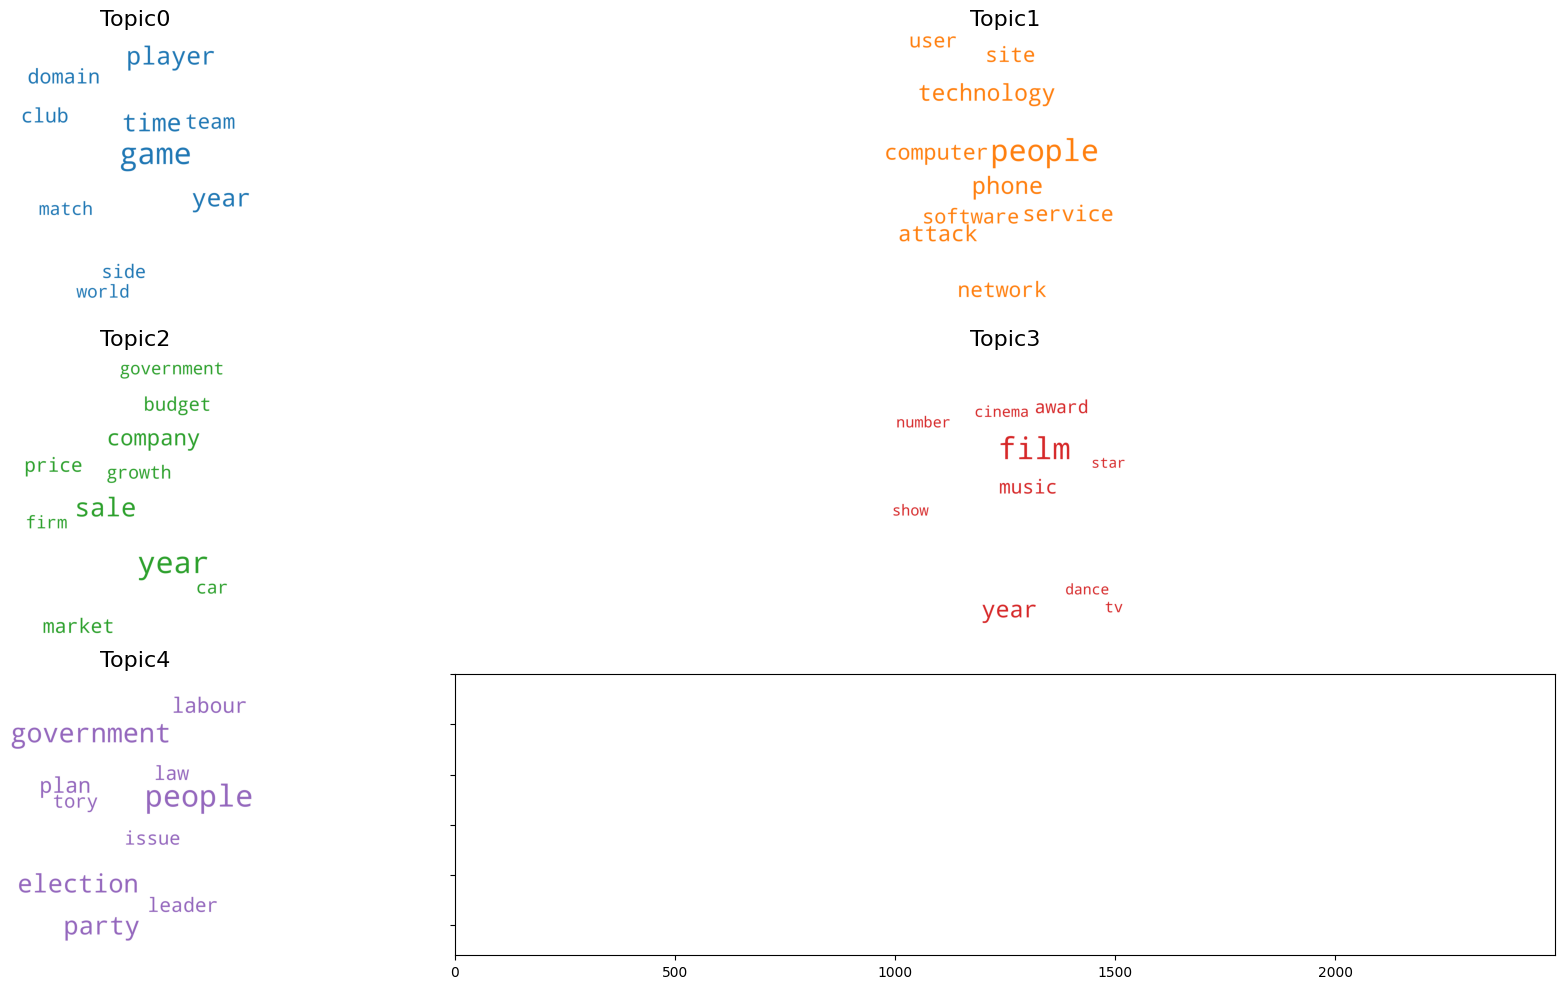

In [ ]:
fig, axes = plt.subplots(2,3, figsize=(20,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    if i < len(topics):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words,max_font_size=300)
        plt.imshow(cloud)
        plt.title('Topic' + str(i), fontdict=dict(size=16))
        plt.axis('off')
plt.axis('off')
plt.tight_layout()
plt.show()
